# Projet MGL869 - Prédiction d'obésité

## Jeu de données

### Contexte

**Jeu de données : Estimation des niveaux d'obésité en fonction des habitudes alimentaires et de la condition physique**

Ce jeu de données comprend des données pour l'estimation des niveaux d'obésité chez des individus des pays du Mexique, du Pérou et de la Colombie, en se basant sur leurs habitudes alimentaires et leur condition physique.

Les données contiennent 17 attributs et 2111 enregistrements, ces enregistrements sont étiquetés avec la variable de classe NObesity (Niveau d'obésité), ce qui permet de classifier les données en utilisant les valeurs suivantes : Insuffisance pondérale, Poids normal, Surpoids Niveau I, Surpoids Niveau II, Obésité Type I, Obésité Type II et Obésité Type III. 77% des données ont été générées synthétiquement à l'aide de l'outil Weka et du filtre SMOTE, 23% des données ont été collectées directement auprès des utilisateurs via une plateforme web.

[Jeu de donnée disponible à cet addresse](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition) (2019)

### 1 - Importation des données

In [119]:
import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, I/O de fichier CSV (par ex. pd.read_csv)
import seaborn as sns # bibliothèque de tracé qui utilise matplot
import matplotlib.pyplot as plt # pour tracer certains paramètres dans seaborn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

df = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

### 2 - Adaptation des types de données

On transforme les données pour que les types correspondent à ceux données sur le site ou est proposé le dataset.

In [120]:
df2 = df.copy();
# Object to category
df2[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]] = df2[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]].astype("category")

# Object to binary
df2["family_history_with_overweight"] = df["family_history_with_overweight"].map({"yes": True, "no": False})
df2["FAVC"] = df["FAVC"].map({"yes": True, "no": False})
df2["SMOKE"] = df["SMOKE"].map({"yes": True, "no": False})
df2["SCC"] = df["SCC"].map({"yes": True, "no": False})

# Float to int
df2[["FCVC", "TUE"]] = df2[["FCVC", "TUE"]].astype("int")


df2.head()

Gender   Age  Height  Weight  family_history_with_overweight   FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            True  False     2   
1  Female  21.0    1.52    56.0                            True  False     3   
2    Male  23.0    1.80    77.0                            True  False     2   
3    Male  27.0    1.80    87.0                           False  False     3   
4    Male  22.0    1.78    89.8                           False  False     2   

   NCP       CAEC  SMOKE  CH2O    SCC  FAF  TUE        CALC  \
0  3.0  Sometimes  False   2.0  False  0.0    1          no   
1  3.0  Sometimes   True   3.0   True  3.0    0   Sometimes   
2  3.0  Sometimes  False   2.0  False  2.0    1  Frequently   
3  3.0  Sometimes  False   2.0  False  2.0    0  Frequently   
4  1.0  Sometimes  False   2.0  False  0.0    0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

### 3 - Intuitions vis à vis du jeu de données

In [121]:
df3 = df2.copy()

L'on remarque la présence des données "height" and "weight" dans notre dataset. En examinant l'article associé, l'on remarque que le niveau d'obésité est dérivé de l'IMC, un calcul ayant pour paramètre la taille et le poids. Si nous conservons ces données dans notre modèle, alors celui-ci ne présente plus d'intéret, car un simple calcul serait plus fiable.

Ainsi, une direction plus appropriée pour notre modèle serait de détermiiner si une personne est sujet à l'obésité à l'aide de caractéristiques autres que la taille et le poids, plus en rapport au mode de vie. Nous supprimons donc ces colonnes.

In [122]:
df3 = df3.drop(columns=["Height", "Weight"])

De plus, un certains nombre de propriétés sont déclarer comme des flotants. Or, quand on regarde les questions posées dans le papier pour l'obtention des informations, les réponses sont données sous forme de catégories avec une relation ordinal. Ce qui fait qu'avoir des nombres à virgules ne fait pas beacoup de sens dans certains cas.

Par exmple, la donnée CH2O représente la quantité d'eau bu par jour :
- 0 : Moins de 1L
- 1 : Entre 1 et 2L
- 2 : Plus de 2L

Dans ce contexte, une valeur de 0.5 ne fait pas de sens.

Pour remédier à ce problème, nous convertissons les données sujet à ce soucis en int.

In [123]:
columns = ["NCP", "CH2O", "FAF"]

for col in columns:
    #round to nearest whole number
    df3[col] = round(df3[col]).astype('int')

df3.head()

Gender   Age  family_history_with_overweight   FAVC  FCVC  NCP       CAEC  \
0  Female  21.0                            True  False     2    3  Sometimes   
1  Female  21.0                            True  False     3    3  Sometimes   
2    Male  23.0                            True  False     2    3  Sometimes   
3    Male  27.0                           False  False     3    3  Sometimes   
4    Male  22.0                           False  False     2    1  Sometimes   

   SMOKE  CH2O    SCC  FAF  TUE        CALC                 MTRANS  \
0  False     2  False    0    1          no  Public_Transportation   
1   True     3   True    3    0   Sometimes  Public_Transportation   
2  False     2  False    2    1  Frequently  Public_Transportation   
3  False     2  False    2    0  Frequently                Walking   
4  False     2  False    0    0   Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_Weight  
3   Overweight_Level_I  
4  Overweight_Level_II

### 4 - Analyse des données


#### Infos et description

In [124]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   category
 1   Age                             2111 non-null   float64 
 2   family_history_with_overweight  2111 non-null   bool    
 3   FAVC                            2111 non-null   bool    
 4   FCVC                            2111 non-null   int32   
 5   NCP                             2111 non-null   int32   
 6   CAEC                            2111 non-null   category
 7   SMOKE                           2111 non-null   bool    
 8   CH2O                            2111 non-null   int32   
 9   SCC                             2111 non-null   bool    
 10  FAF                             2111 non-null   int32   
 11  TUE                             2111 non-null   int32   
 12  CALC                

On remarque qu'il n'y a pas de valeur NaN. Nous n'avons donc pas d'étape de supression des NaNs à effectuer.

In [125]:
df3.describe()

Age         FCVC          NCP         CH2O          FAF  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     2.213169     2.687826     2.014685     1.006632   
std       6.345968     0.599397     0.809680     0.688616     0.895462   
min      14.000000     1.000000     1.000000     1.000000     0.000000   
25%      19.947192     2.000000     3.000000     2.000000     0.000000   
50%      22.777890     2.000000     3.000000     2.000000     1.000000   
75%      26.000000     3.000000     3.000000     2.000000     2.000000   
max      61.000000     3.000000     4.000000     3.000000     3.000000   

               TUE  
count  2111.000000  
mean      0.381336  
std       0.582536  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       2.000000

On remarque que la portée des données diffères beacoup entre l'âge et les valeurs ordinals. Nous aurons donc besoin d'une normalisation ou d'une standardisation.

In [126]:
df3.describe(include=["category"])

Gender       CAEC       CALC                 MTRANS      NObeyesdad
count    2111       2111       2111                   2111            2111
unique      2          4          4                      5               7
top      Male  Sometimes  Sometimes  Public_Transportation  Obesity_Type_I
freq     1068       1765       1401                   1580             351

La présence de données catégoriels nous indique la nécéssité de mettre en place du one hot encoding pour ces valeurs.

#### Donnée numérique floatants

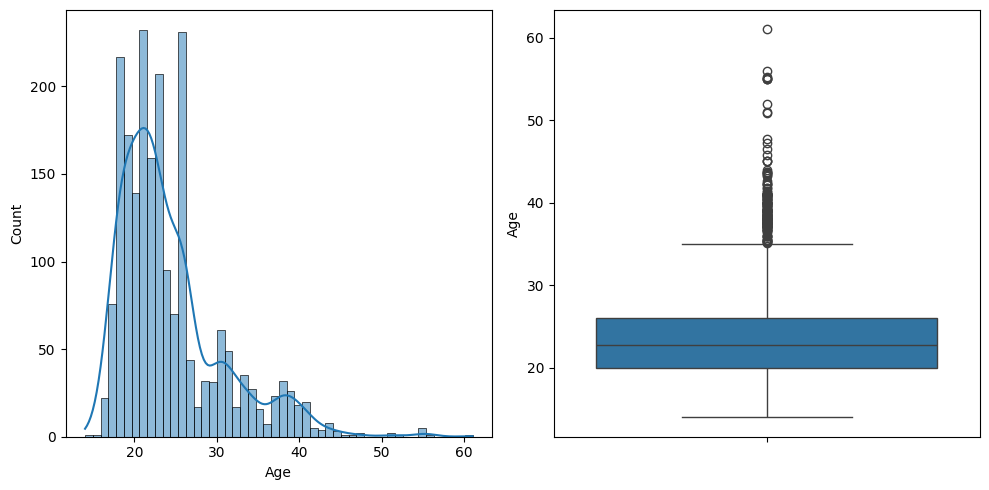

In [127]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes = axes.flatten()

sns.histplot(df3["Age"], kde=True, ax=axes[0])
sns.boxplot(df3["Age"], ax=axes[1])
plt.tight_layout()
plt.show()

- **Age**
  - Type de valeur : Numérique continue
  - Distribution : Non normal
  - Problèmes : Données non normalisée
    - *Solution 1* : Appliquer Log10() pour normaliser la distribution
      - Ne marche pas dans ce cas (voir exemple)
    - *Solution 2* : Transformer la valeur en valeur categoriel
    - *Solution 3* : Garder les données tel quelles
  - Box plot : Indication de outliers
    - Cependant, données vérifiées car il s'agit d'un âge

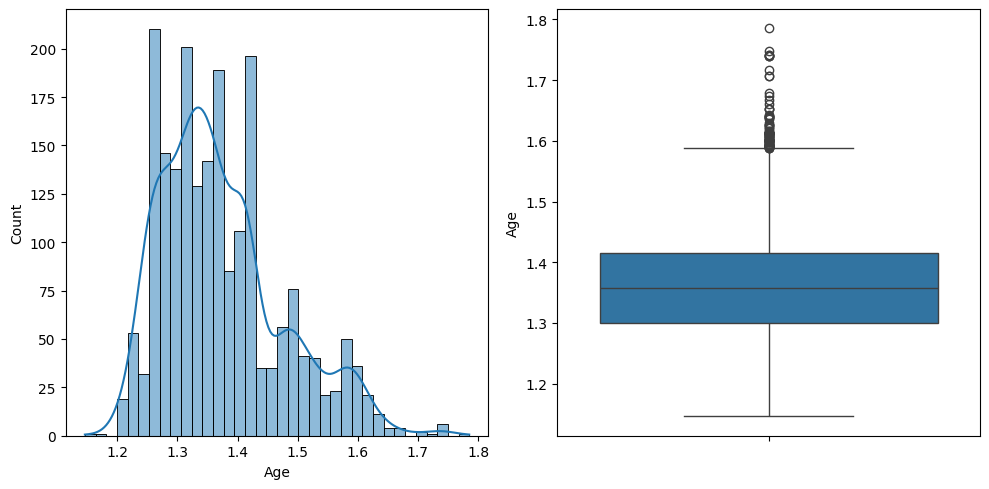

In [128]:
log_example = np.log10(df3["Age"])

fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes = axes.flatten()

sns.histplot(log_example, kde=True, ax=axes[0])
sns.boxplot(log_example, ax=axes[1])
plt.tight_layout()
plt.show()

#### Donnée numériques int

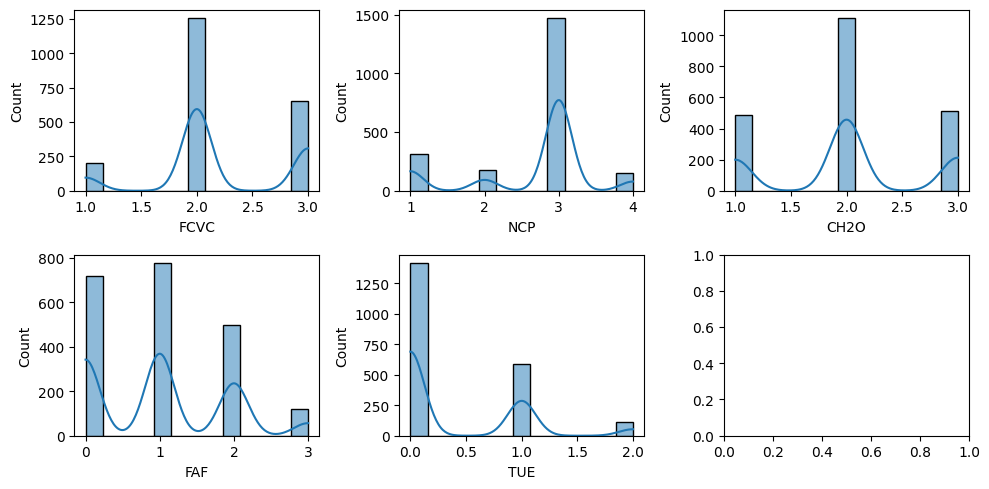

In [129]:
fig, axes = plt.subplots(2,3, figsize=(10, 5))
axes = axes.flatten()

for ax, col in zip(axes, ["FCVC", "NCP", "CH2O", "FAF", "TUE"]) :
    sns.histplot(df3[col], kde=True, ax=ax)

plt.tight_layout()
plt.show()

**Données**

- FCVC (Légumes dans les repas)
- NCP (Nombre de repas par jour)
- CH2O (Quantité d'eau bu par jour)
- FAF (Fréquence activité physique)
- TUE (Temps passé sur les écrans)

**Problèmes**  
Données non équilibrés

**Solutions**  
Downsampling et Upweighting. Il s'agit de deux techniques de construction de set de données permetant de mitiger les problèmes de données non équilibrés. Cependant, le déséquilibre n'etant pas extrème, nous n'implementerons pas cette solution.

**Remarques**  
De part leur nature, l'on pourrait penser les convertir en catégorie. Cependant, ces variables présentent des relations ordinales qu'il convient de conserver pour améliorer la justesse du modèle.

#### Données catégoriels et booléenes

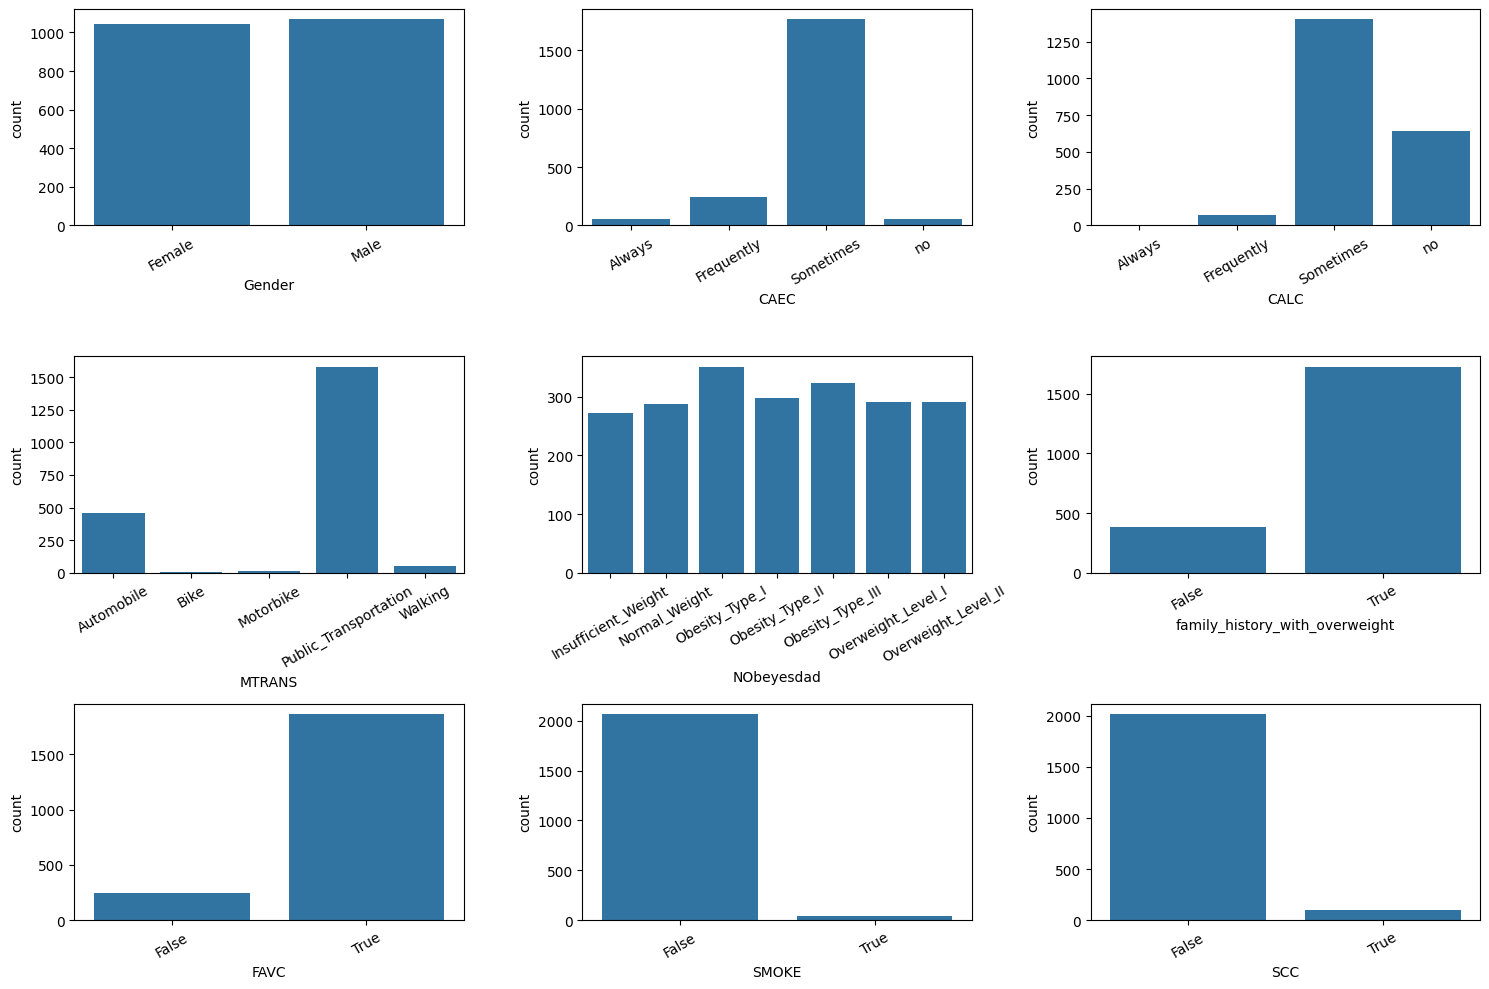

In [130]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, ["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]) :
    sns.countplot(x=df3[col], ax=ax)
    ax.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

**Données**

- Gender
- CAEC (Nourriture entre les repas)
- CALC (Fréquence alcool)
- MTRANS (Moyen de transport)
- Nobeyesdad (Catégorie d'obésité) (variable cible)
- family_history_with_overweight
- FAVC (Consomation fréquente de nourriture à haute calories)
- SMOKE
- SCC (Surveillance des calories)

**Problèmes**  
1. Données non équilibrés

**Solutions**  
1. Downsampling et Upweighting. Il s'agit de deux techniques de construction de set de données permetant de mitiger les problèmes de données non équilibrés. Cependant, le déséquilibre n'etant pas extrème, nous n'implementerons pas cette solution.

**Remarques**  
Certaines de ces catégories (CAEC, CALC, Nobeyesdad) ont des relation que l'on pourrait considérer ordinal. Conserver cette relation pourrait être intéréssant, nous pouvons donc appliquer un encoder oridinal sur ces valeurs.

#### Matrice de corrélation

In [131]:
corr_matrix = df3.select_dtypes(exclude=['category']).corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

L'on conclut qu'aucune valeurs ne sont manifestement corrélées entre elles.


### 5 - Pipeline

Avec notre analyse, nous pouvons imaginer la pipelines suivantes:
- Suppresion des colonnes "Height" et "Weight"
- Transformation des colonnes restantes aux types spécifiées
- Conversions des données flotantes en int (sauf pour âge)
  - Optionnel -> Convertir Age en catégorie
- Appliquer le Ordinal Encoding sur CAEC, CALC et Nobeyesdad
- Appliquer le OneHot Encoding sur Gender, MTRANS, familiy_history_with_overweight, FAVC
- Normaliser l'ensemble des données

In [132]:
def prepareData(df):
    # Drop columns
    prepared_df = df.drop(columns=["Height", "Weight"])

    # Objects to category
    prepared_df[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]] = prepared_df[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]].astype("category")
    
    # Object to binary
    prepared_df["family_history_with_overweight"] = prepared_df["family_history_with_overweight"].map({"yes": True, "no": False})
    prepared_df["FAVC"] = prepared_df["FAVC"].map({"yes": True, "no": False})
    prepared_df["SMOKE"] = prepared_df["SMOKE"].map({"yes": True, "no": False})
    prepared_df["SCC"] = prepared_df["SCC"].map({"yes": True, "no": False})

    # Float to int
    prepared_df[["FCVC", "TUE"]] = prepared_df[["FCVC", "TUE"]].astype("int")

    # Transform senseless floats into ints
    for col in ["NCP", "CH2O", "FAF"]:
        #round to nearest whole number
        prepared_df[col] = round(prepared_df[col]).astype('int')

    # Ordinal encoding
    ord_enc = OrdinalEncoder()
    prepared_df[["CAEC", "CALC", "NObeyesdad"]] = ord_enc.fit_transform(prepared_df[["CAEC", "CALC", "NObeyesdad"]])

    # One Hot encoding
    prepared_df = pd.get_dummies(prepared_df, columns=["Gender", "MTRANS", "family_history_with_overweight", "FAVC"])
    prepared_df.replace({False: 0, True: 1}, inplace=True)
    
    return prepared_df

df_final = prepareData(df)
df_final.head()



C:\Users\felix\AppData\Local\Temp\ipykernel_43320\4090555811.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prepared_df.replace({False: 0, True: 1}, inplace=True)


Age  FCVC  NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  ...  Gender_Male  \
0  21.0     2    3   2.0      0     2    0    0    1   3.0  ...            0   
1  21.0     3    3   2.0      1     3    1    3    0   2.0  ...            0   
2  23.0     2    3   2.0      0     2    0    2    1   1.0  ...            1   
3  27.0     3    3   2.0      0     2    0    2    0   1.0  ...            1   
4  22.0     2    1   2.0      0     2    0    0    0   2.0  ...            1   

   MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
0                  0            0                 0   
1                  0            0                 0   
2                  0            0                 0   
3                  0            0                 0   
4                  0            0                 0   

   MTRANS_Public_Transportation  MTRANS_Walking  \
0                             1               0   
1                             1               0   
2                             1               0   
3                             0               1   
4                             1               0   

   family_history_with_overweight_False  family_history_with_overweight_True  \
0                                     0                                    1   
1                                     0                                    1   
2                                     0                                    1   
3                                     1                                    0   
4                                     1                                    0   

   FAVC_False  FAVC_True  
0           1          0  
1           1          0  
2           1          0  
3           1          0  
4           1          0  

[5 rows x 22 columns]

### 6 - Partitionnement des données

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# df4 = pd.DataFrame(df3)
df4 = prepareData(df)
X = df4.drop(['NObeyesdad'], axis=1)
X_columns = X.columns
y = df4['NObeyesdad']


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


C:\Users\felix\AppData\Local\Temp\ipykernel_43320\4090555811.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prepared_df.replace({False: 0, True: 1}, inplace=True)


### 7 - Mise en oeuvre du modèle : RandomForest

In [134]:
"""param_grid = {
    'n_estimators': [400, 420, 450, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [False]
}"""

"""param_grid = {
    'n_estimators': [400, 430, 450, 470, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [False]
}"""

param_grid = {
    'n_estimators': [100, 125, 140, 150, 160, 175],
    'max_depth': [7, 9, 15, 17],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [False]
}

model = RandomForestClassifier(random_state=1)

Optimisation des hyper paramètres avec GridSearch

In [135]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [7, 9, 15, 17],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 125, 140, 150, 160, 175]})

Evaluation du modèle RandomForest

In [136]:
y_val_pred = grid_search.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8009478672985783


Visualisation d'un arbre

In [137]:
from sklearn import tree

clf = grid_search.best_estimator_.estimators_[0]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,10), dpi=1200)
tree.plot_tree(clf,
           feature_names = X_columns, 
           class_names=["under", "ok", "ov1", "ov2", "ob1", "ob2", "ob3"],
           filled = True);

### 8 - Mise en oeuvre du modèle : DecisionTreeClassifier

In [138]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=1)


Entraîner le modèle DecisionTreeClassifier sur les données d'entraînement


In [139]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

Résultat de Cross-validation sur l'arbre de décision

In [140]:
from sklearn.model_selection import cross_val_score
cv_dt = cross_val_score(dt_clf, X_train, y_train, cv=10)

print(cv_dt)
print(cv_dt.mean())

[0.67716535 0.68503937 0.73228346 0.7480315  0.73228346 0.70866142
 0.71428571 0.67460317 0.76190476 0.69047619]
0.7124734408198975


Évaluer le modèle DecisionTreeClassifier sur les données de validation

In [141]:
from sklearn.metrics import recall_score, f1_score
y_pred_val = dt_clf.predict(X_val)

acc_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val}")

recall_val = recall_score(y_val, y_pred_val, average='macro')
print(f"Rappel sur les données de validation : {recall_val}")

f1_val = f1_score(y_val, y_pred_val, average='macro')
print(f"F1 score sur les données de validation : {f1_val}")

cm_val = confusion_matrix(y_val, y_pred_val)

print(cm_val)

Accuracy sur les données de validation : 0.7037914691943128
Rappel sur les données de validation : 0.7038499892040644
F1 score sur les données de validation : 0.7030757147973052
[[43 10  0  0  0  2  3]
 [ 8 23  8  1  0  7  4]
 [ 2  5 43  3  1  5  3]
 [ 0  1  6 54  0  0  5]
 [ 0  1  0  0 52  0  0]
 [ 3  9  7  2  0 39  4]
 [ 3  3  7  8  0  4 43]]


Évaluer le modèle DecisionTreeClassifier sur les données de test

In [142]:
y_pred_test = dt_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur les données de test : {acc_test:.2f}")

Accuracy sur les données de test : 0.69


Test d'optimisation des hyperparamètres avec GridSearch

In [143]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Créer une grille de recherche d'hyperparamètres
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 100],
    'min_samples_split': [2, 5, 100],
    'min_samples_leaf': [1, 3, 40],
}

# Créer une instance de GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

# Entraîner le modèle DecisionTreeClassifier avec GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le meilleur score
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score : {grid_search.best_score_}")

# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de validation
y_pred_val = grid_search.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val}")

# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de test
y_pred_test = grid_search.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur les données de test : {acc_test}")

Meilleurs hyperparamètres : {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Meilleur score : 0.6816745655608215
Accuracy sur les données de validation : 0.7014218009478673
Accuracy sur les données de test : 0.7115839243498818


Test d'optimisation des hyperparametres avec la recherche aléatoire

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Créer une grille de recherche d'hyperparamètres aléatoires
param_distribs = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': sp_randint(10, 100),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10),
    'min_weight_fraction_leaf': sp_uniform(0, 0.5),
    'random_state': sp_randint(0, 100),
    'max_leaf_nodes': sp_randint(10, 100),
    'min_impurity_decrease': sp_uniform(0, 0.1),
    'ccp_alpha': sp_uniform(0, 1)
}

# Créer une instance de DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()

# Créer une instance de RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_clf,
    param_distributions=param_distribs,
    scoring='accuracy',
    cv=5,
    n_iter=100,
    n_jobs=-1,
    verbose=1
)

# Entraîner le modèle DecisionTreeClassifier avec RandomizedSearchCV sur les données d'entraînement
random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le meilleur score
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score : {random_search.best_score_:.2f}")

# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de validation
y_pred_val = random_search.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val:.2f}")

# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de test
y_pred_test = random_search.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur les données de test : {acc_test:.2f}")



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Meilleurs hyperparamètres : {'ccp_alpha': 0.22353429833151728, 'criterion': 'log_loss', 'max_depth': 68, 'max_leaf_nodes': 29, 'min_impurity_decrease': 0.0820191062093325, 'min_samples_leaf': 9, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1649577724839631, 'random_state': 34, 'splitter': 'random'}
Meilleur score : 0.37
Accuracy sur les données de validation : 0.34
Accuracy sur les données de test : 0.36


### Modèle : SVC Linéaire

In [145]:
from sklearn.svm import LinearSVC

# Créer une instance de LinearSVC
lsvc_clf = LinearSVC(random_state=42)

# Entraîner le modèle LinearSVC sur les données d'entraînement
lsvc_clf.fit(X_train, y_train)

# Évaluer le modèle LinearSVC sur les données de validation
y_pred_val = lsvc_clf.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val:.2f}")

# Évaluer le modèle LinearSVC sur les données de test
y_pred_test = lsvc_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur les données de test : {acc_test:.2f}")


Accuracy sur les données de validation : 0.53
Accuracy sur les données de test : 0.56


In [146]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Créer une grille de recherche d'hyperparamètres
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Créer une instance de LinearSVC
lsvc_clf = LinearSVC(random_state=42)

# Créer une instance de GridSearchCV
grid_search = GridSearchCV(
    estimator=lsvc_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entraîner le modèle LinearSVC avec GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le meilleur score
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Meilleur score : {grid_search.best_score_:.2f}")

# Évaluer le modèle LinearSVC optimisé sur les données de validation
y_pred_val = grid_search.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val:.2f}")

# Évaluer le modèle LinearSVC optimisé sur les données de test
y_pred_test = grid_search.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur les données de test : {acc_test:.2f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs hyperparamètres : {'C': 0.1, 'penalty': 'l1'}
Meilleur score : 0.55
Accuracy sur les données de validation : 0.51
Accuracy sur les données de test : 0.55
